In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

sys.path.append(r'C:\Users\avido\Documents\other code\AlgoTrading')
import utils

sys.path.append(r'C:\Users\avido\Documents\other code\Signal_processing_and_timeseries_exploration')
import dsp_utils as dsp


In [2]:
#open and combine all data
folder = os.path.join('..', 'data', 'scraped_OHLC')
key = 'close'
window_size = 60*4

prices = []
for file in os.listdir(folder):
    vals = pd.read_csv(os.path.join(folder, file))[key].values.tolist()
    print(f'file: {file}, norm std of diffs: {np.std(np.diff(vals))/np.mean(vals)}')
    prices.extend(vals)

#convert to numpy array
prices = np.array(prices)

# drop na
prices = prices[~np.isnan(prices)]

#reshape 
final_len = len(prices) - len(prices) % window_size
prices = prices[0:final_len].reshape(-1, window_size)

#normalize each window  so origin = 1
prices = prices/prices[:, 0].reshape(-1, 1)

#drop rows with nan
prices = prices[~np.isnan(prices).any(axis=1)]


file: ADAUSD.csv, norm std of diffs: 0.012484578520601934
file: ALGOUSD.csv, norm std of diffs: 0.010407566813177878
file: BTCUSD.csv, norm std of diffs: 0.0007422632985567171
file: DOTUSD.csv, norm std of diffs: 0.002146666447740113
file: ETHUSD.csv, norm std of diffs: 0.00737314864892973
file: SOLUSD.csv, norm std of diffs: 0.010285652817791284
file: XRPUSD.csv, norm std of diffs: 0.011372465052022582


In [3]:
prices.shape

(22566, 240)

In [4]:
random_walks = []
for i in range(prices.shape[0]):
    # random_walks.append(dsp.normal_random_walk(window_size, init_val = 1, std = .0015))
    random_walks.append(dsp.empiricle_random_walk(window_size, dts = np.diff(prices[i, :])))
    
#convert to numpy
random_walks = np.array(random_walks)

random_walks.shape


(22566, 240)

In [5]:
random_walks[0]

array([0.        , 0.00061169, 0.00060961, 0.00043306, 0.00123168,
       0.00183506, 0.00226916, 0.00226605, 0.00239274, 0.00239274,
       0.00239274, 0.00177794, 0.00160036, 0.00157543, 0.00139784,
       0.00139784, 0.00139784, 0.00057845, 0.00057845, 0.00128776,
       0.00128776, 0.00128776, 0.00082251, 0.00084951, 0.00095959,
       0.00095959, 0.00095959, 0.0023564 , 0.0023564 , 0.00235536,
       0.00235328, 0.00235328, 0.00138019, 0.00205315, 0.00143835,
       0.00140511, 0.00308128, 0.00509808, 0.00509808, 0.00509808,
       0.00509808, 0.00509808, 0.00577104, 0.00632769, 0.00582297,
       0.00582297, 0.00588839, 0.00683448, 0.00683656, 0.00678775,
       0.00678775, 0.00678775, 0.00675452, 0.00700999, 0.0069913 ,
       0.00742436, 0.00812121, 0.00812121, 0.0085065 , 0.00821571,
       0.00821571, 0.0088274 , 0.0088274 , 0.0088274 , 0.0088274 ,
       0.0088274 , 0.0088274 , 0.00893748, 0.00893644, 0.00893644,
       0.00832164, 0.0068376 , 0.0068376 , 0.00663924, 0.00681

In [6]:
class price_vs_random_walk_dataset(Dataset):
    def __init__(self, price_array, random_walk_array):
        self.data = np.concatenate([price_array, random_walk_array], axis=0)
        self.labels = np.concatenate([np.ones(price_array.shape[0]), np.zeros(random_walk_array.shape[0])])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # if self.data[idx][0] == 0:
        #     x = torch.tensor(self.data[idx])
        # else:
        #     x = torch.tensor(self.data[idx]) / torch.tensor(self.data[idx][0])
        x = torch.tensor(self.data[idx]).diff()
        y = torch.tensor(self.labels[idx])
        # if y == 1:
            # y = torch.tensor([0, 1])
            # x += .002
        # else:
            # y = torch.tensor([1, 0])
        return torch.unsqueeze(x, 0).to(torch.float), torch.unsqueeze(torch.unsqueeze(y, 0), 0).to(torch.float)
    
train_test_split = .8
train_size = int(train_test_split * len(prices))

train_dl = DataLoader(price_vs_random_walk_dataset(prices[:train_size], random_walks[:train_size]), batch_size=128, shuffle=True)
test_dl = DataLoader(price_vs_random_walk_dataset(prices[train_size:], random_walks[train_size:]), batch_size=128, shuffle=True)

In [7]:
itrtr = iter(train_dl)
x, y, = next(itrtr)
x.shape, y.shape

(torch.Size([128, 1, 239]), torch.Size([128, 1, 1]))

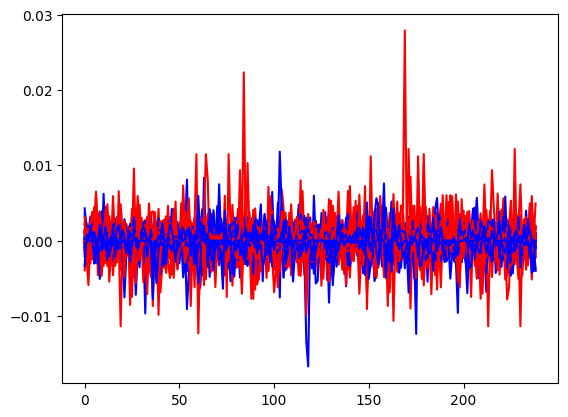

In [8]:
#plot all samples
for i in range(len(x)):
    if y[i] == 1:
        plt.plot(x[i,0,:].numpy(), c='b')
    else:
        plt.plot(x[i,0,:].numpy(), c='r')

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.dropout1 = nn.Dropout(0.2)
        self.conv1 = nn.Conv1d(1, 128, 16, padding=1)
        self.conv2 = nn.Conv1d(128, 64, 8, padding=1)
        self.conv3 = nn.Conv1d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv1d(32, 1, 3, padding=1)
        self.parallell_fc1 = nn.LazyLinear(128)
        self.parallell_fc2 = nn.LazyLinear(128)
        self.parallell_fc3 = nn.LazyLinear(128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(128)
        self.fc3 = nn.LazyLinear(128)
        self.fc4 = nn.LazyLinear(64)
        self.fc5 = nn.LazyLinear(1)
        self.loss_fn = nn.BCEWithLogitsLoss()
        
        
        
    def forward(self, x):
        x = self.dropout1(x)
        
        x_conv = self.conv1(x)
        x_conv = F.max_pool1d(x_conv, 3)
        x_conv = F.leaky_relu(x_conv)
        x_conv = self.conv2(x_conv)
        x_conv = F.max_pool1d(x_conv, 3)
        x_conv = F.leaky_relu(x_conv)
        x_conv = self.conv3(x_conv)
        x_conv = F.leaky_relu(x_conv)
        x_conv = self.conv4(x_conv)
        x_conv = F.leaky_relu(x_conv)
        
        x_linear = self.parallell_fc1(x)
        x_linear = F.leaky_relu(x_linear)
        x_linear = self.parallell_fc2(x_linear)
        x_linear = F.leaky_relu(x_linear)
        x_linear = self.parallell_fc3(x_linear)
        x_linear = F.leaky_relu(x_linear)
         
        x = torch.cat([x_conv, x_linear], dim=-1)
        
        x = self.dropout2(x)
        # x = torch.flatten(x, 2)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.leaky_relu(x)
        x = self.fc5(x)
        return x
    
print(Model()(x).shape)    

torch.Size([128, 1, 1])


In [17]:
# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.fc1 = nn.LazyLinear(128)
#         self.fc2 = nn.LazyLinear(128)
#         self.fc3 = nn.LazyLinear(128)
#         self.fc4 = nn.LazyLinear(64)
#         self.fc5 = nn.LazyLinear(1)
#         self.loss_fn = nn.BCELoss()
        
        
        
#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.leaky_relu(x)
#         x = self.fc2(x)
#         x = F.leaky_relu(x)
#         x = self.fc3(x)
#         x = self.fc4(x)
#         x = F.leaky_relu(x)
#         x = self.fc5(x)
#         x = F.sigmoid(x)
#         return x
    
# model = Model()
# print(model(x).shape)    

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Model()
model = model.to(device) # GPU
train_losses = []
test_losses = []

def train_loop(model, data, lr=.001):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    _losses = []
    for i, (x, y) in enumerate(data):
        if torch.isinf(x).any():
            print('x has nans')
        x = x.to(device) # GPU
        y = y.to(device)
        opt.zero_grad()
        x_hat = model(x)
        if torch.isnan(x_hat).any() or torch.isinf(x_hat).any():
            print('x_hat has nans')
        loss = model.loss_fn(x_hat, y)
        loss.backward()
        opt.step()
        _losses.append(loss.detach().cpu().numpy())
        print(f'epoch: {epoch}, batch: {i}, loss: {loss}', end='\r')
    train_losses.append(np.mean(_losses))
    return model


def test_loop(model, data):
    model.eval()
    with torch.no_grad():
        _losses = []
        for i, (x, y) in enumerate(data):
            x = x.to(device) # GPU
            y = y.to(device)
            x_hat = model(x)
            loss = model.loss_fn(x_hat, y)
            print(f'epoch: {epoch}, batch: {i}, loss: {loss}', end='\r')
            _losses.append(loss.detach().cpu().numpy())
        test_losses.append(np.mean(_losses))

In [12]:
num_epochs = 1000
for epoch in range(num_epochs):
    model = train_loop(model, train_dl, lr=0.0005)
    test_loop(model, test_dl)

KeyboardInterrupt: 

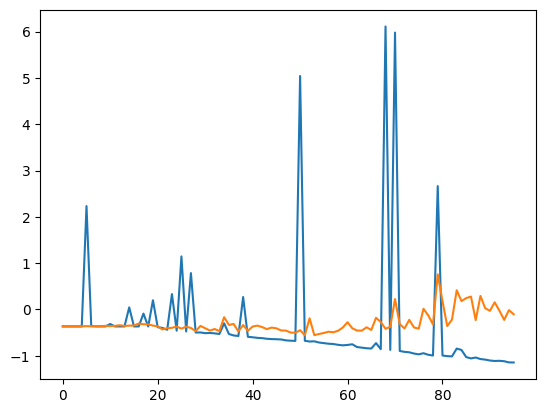

In [13]:
plt.plot([np.log(loss) for loss in train_losses])
plt.plot([np.log(loss) for loss in test_losses])

In [64]:
#test on test set
model.eval()
losses = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_dl):
        x = x.to(device) # GPU
        y = y.to(device)
        x_hat = model(x)
        loss = model.loss_fn(x_hat, y)
        print(f'batch: {i}, loss: {loss}', end='\r')
        losses.append(loss.detach().cpu().numpy())
print(f'test loss: {np.mean(losses)}')

test loss: 0.088731624186038972605135


In [65]:
#save model
savepath = os.path.join('model_checkpoints', 'random_walk_classification_1.pt')
torch.save(model.state_dict(), savepath)